# APPM 5720 Biweekly Report - Part 1
### *Alexey Yermakov*
### *December 10 2022*

# Summary


# Main Content

All code and comments in this notebook are mine unless otherwise explicitly stated. (There is some code I copied but I make it clear where as well as where I copied it from).

First, lets import some useful packages that may be used in this report. Note that some of these may not be used, but they were useful in my previous reports. I also always like to make sure my GPU is available in case there may be any performance benefits, but since I'm not training anything in this report it may not be useful.

In [12]:
# Make sure Torch is installed and our GPU is available
import torch
import numpy as np
from torch import nn, permute, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import urllib
from PIL import Image
import time
import os

!echo $CUDA_VISIBLE_DEVICES

print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


GPU Available? True


Now I can load the Cityscapes dataset from the [downloads](https://www.cityscapes-dataset.com/downloads/) page. I had to download `gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip`. [This Github Page](https://github.com/mcordts/cityscapesScripts) explains the different files available for download. These two zip files together will allow me to parse the training, testing, and validation datasets.

In [13]:
# Start timer
start_time = time.time()

# Load our dataset that we downloaded

verbose = 1
cs_dir = '/home/alexey/Datasets/Cityscapes/'
target_type = ['instance', 'color', 'polygon', 'semantic']

def create_data_loaders():
    '''
    `create_data_loaders`

    Load our MNIST dataset and return the training and testing dataloader
    '''
    # Load dataset
    train_data = datasets.Cityscapes(
        root=cs_dir,
        split='train',
        mode='fine',
        target_type=target_type,
        transform=ToTensor()
    )
    test_data = datasets.Cityscapes(
        root=cs_dir,
        split='test',
        mode='fine',
        target_type=target_type,
        transform=ToTensor()
    )
    val_data = datasets.Cityscapes(
        root=cs_dir,
        split='val',
        mode='fine',
        target_type=target_type,
        transform=ToTensor()
    )

    if verbose:
        train_sz = len(train_data)
        test_sz = len(test_data)
        val_sz = len(val_data)
        total_sz = (train_sz + test_sz + val_sz)
        print(f"Training data size: {train_sz}/{total_sz} ({train_sz/total_sz*100:02.2f}%)")
        print(f"Testing data size: {test_sz}/{total_sz} ({test_sz/total_sz*100:02.2f}%)")
        print(f"Validation data size: {val_sz}/{total_sz} ({val_sz/total_sz*100:02.2f}%)")

    return train_data, test_data, val_data

train_data, test_data, val_data = create_data_loaders()

Training data size: 2975/5000 (59.50%)
Testing data size: 1525/5000 (30.50%)
Validation data size: 500/5000 (10.00%)


Great! So after we downloaded and loaded the dataset we can see that the majority of the data is the training data at 59.50%, then the testing data is the second largest at 30.50%, with the validation data being 10% of the images. However, it's interesting to note that this dataset is relatively small at 5,000 images. This is likely because it's hard to label a single image so it's harder to get a dataset as large as imagenet since the labeling process is much more difficult. This is supported by the fact that there are an additional [20,000 images](https://www.cityscapes-dataset.com/dataset-overview/#features) that are "coarsely" annotated, meaning the edges of the objects aren't as strict as the "finely" annotated images. In this report I look at the "fine" images since they're much better for viewing purposes and are more interesting as a result.

Below is code I copied from the [cityscapesScripts](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) Github repo. This will help me map ID's to labels. This code is not mine.

In [2]:
from __future__ import print_function, absolute_import, division
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# Please refer to the main method below for example usages!

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

#--------------------------------------------------------------------------------
# Assure single instance name
#--------------------------------------------------------------------------------

# returns the label name that describes a single instance (if possible)
# e.g.     input     |   output
#        ----------------------
#          car       |   car
#          cargroup  |   car
#          foo       |   None
#          foogroup  |   None
#          skygroup  |   None
def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name

#--------------------------------------------------------------------------------
# Main for testing
#--------------------------------------------------------------------------------

# just a dummy main
if __name__ == "__main__":
    # Print all the labels
    print("List of cityscapes labels:")
    print("")
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval' ))
    print("    " + ('-' * 98))
    for label in labels:
        print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval ))
    print("")

    print("Example usages:")

    # Map from name to label
    name = 'car'
    id   = name2label[name].id
    print("ID of label '{name}': {id}".format( name=name, id=id ))

    # Map from ID to label
    category = id2label[id].category
    print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

    # Map from trainID to label
    trainId = 0
    name = trainId2label[trainId].name
    print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1
     rectification border |   2 |     255 |           void |          0 |            0 |            1
               out of roi |   3 |     255 |           void |          0 |            0 |            1
                   static |   4 |     255 |           void |          0 |            0 |            1
                  dynamic |   5 |     255 |           void |          0 |            0 |            1
                   ground |   6 |     255 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

Now that we have our dataset and labels loaded, lets see what the dataset gives us:

Image size    torch.Size([1024, 2048, 3])
image type    <class 'torch.Tensor'>
instance type <class 'PIL.PngImagePlugin.PngImageFile'>
color type    <class 'PIL.PngImagePlugin.PngImageFile'>
polygon type  <class 'dict'>
semantic type <class 'PIL.PngImagePlugin.PngImageFile'>

Image:


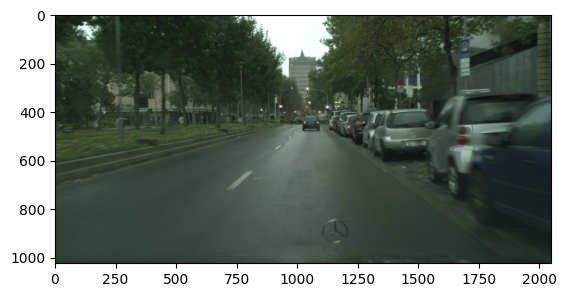

Color:


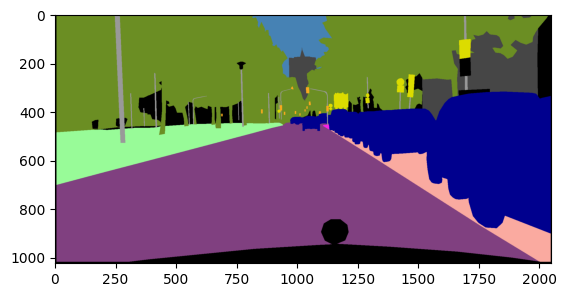

Pixel (100,100): tensor([107, 142,  35, 255], dtype=torch.uint8)
Pixel (600,2000): tensor([  0,   0, 142, 255], dtype=torch.uint8)
Pixel (1000,1000): tensor([  0,   0,   0, 255], dtype=torch.uint8)

Instance:


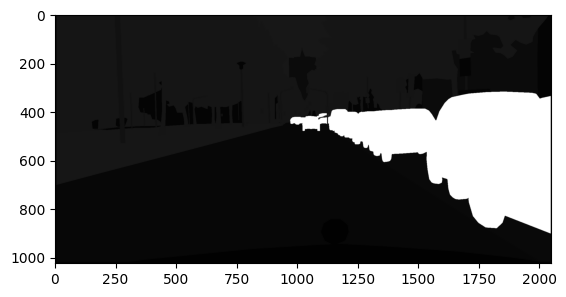

Semantic:


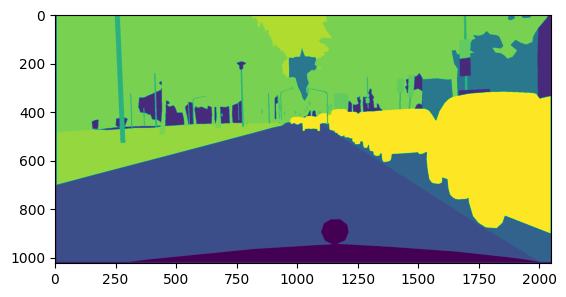

Pixel (100,100): tensor([21], dtype=torch.uint8)
Pixel (600,2000): tensor([26], dtype=torch.uint8)
Pixel (1000,1000): tensor([1], dtype=torch.uint8)


In [4]:
# Get all of the label data for image 0 and plot what we can

img, (inst, col, poly, sem) = train_data[0]
img = torch.permute(img, (1,2,0))
print("Image size   ",img.size())

print("image type   ",type(img))
print("instance type",type(inst))
print("color type   ",type(col))
print("polygon type ",type(poly))
print("semantic type",type(sem))

print()

print("Image:")
plt.imshow(img)
plt.show()
plt.close()

print("Color:")
plt.imshow(col)
plt.show()
plt.close()
col_t = transforms.functional.pil_to_tensor(col)
col_t = torch.permute(col_t, (1,2,0))
print("Pixel (100,100):",col_t[100][100])
print("Pixel (600,2000):",col_t[600][2000])
print("Pixel (1000,1000):",col_t[1000][1000])
print()

# Throws an error since it's not an image

#print("Polygon:")
#plt.imshow(poly)
#plt.show()
#plt.close()

print("Instance:")
plt.imshow(inst)
plt.show()
plt.close()

print("Semantic:")
plt.imshow(sem)
plt.show()
plt.close()
sem_t = transforms.functional.pil_to_tensor(sem)
sem_t = torch.permute(sem_t, (1,2,0))
print("Pixel (100,100):",sem_t[100][100])
print("Pixel (600,2000):",sem_t[600][2000])
print("Pixel (1000,1000):",sem_t[1000][1000])

In [5]:
# Print polygon labels 0 and 1
print(poly['objects'][0])
print(poly['objects'][1])

{'label': 'sky', 'polygon': [[1182, 0], [1215, 138], [1103, 286], [901, 300], [678, 0]]}
{'label': 'road', 'polygon': [[0, 1023], [1, 547], [918, 435], [1179, 424], [2048, 596], [2048, 1024], [1, 1024]]}


Sweet! So from the above, it's clear that for the first image, we have 4 different kinds of labels:
- Polygon: This isn't an image, in fact, it is a collection of labels where each object is enclosed within a polygon. The format of this is seen in a code block above. I'm sure there is a way to plot this as an SVG but I didn't bother.
- Color: This is what we're used to, where each pixel is assigned a label depending on the object it is a part of.
- Instance: This appears to be for training to identify cars. Although it also looks like it has some other information there. I won't worry about this since it's difficult to see visually to our human eyes.
- Semantic: This looks the same as the Color label, except it is less visually pleasing lol. In fact, during experimentation (and printed above) I found that the semantic labeling is easier to use for EDA since each pixel is an 8-bit integer, whereas in the color label each pixel is an RGB color. I'll be using the semantic labels for the rest of this report since it's easier to use.

Lets count the number of different times a label appears in the semantic label. Note that each pixel in the semantic labeling is a single 8-bit integer. I first plot the image, then make a table of its labels.

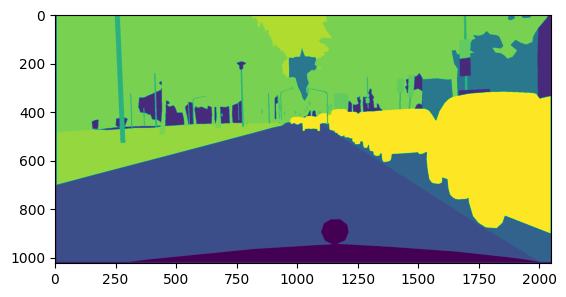

Size torch.Size([1024, 2048, 1])
Width 2048
Height 1024
Total pixels 2097152
tensor([21], dtype=torch.uint8)


In [6]:
# Plot semantic image for image 0 and count how many times each label appears (pixel-wise)

#img, (inst, col, poly, sem) = train_data[0]
sem_t = transforms.functional.pil_to_tensor(sem)
sem_t = torch.permute(sem_t, (1,2,0))
plt.imshow(sem_t)
plt.show()
plt.close()

sz = sem_t.size()
w = sz[1]
h = sz[0]
total_pixels = w*h

print("Size",sz)
print("Width",w)
print("Height",h)
print("Total pixels",total_pixels)

found_labels = np.int_(np.zeros(35))

for r in range(h):
    for c in range(w):
        color = sem_t[r][c].item()
        found_labels[color] += 1

print(sem_t[100][100])

In [7]:
# Plot a pretty table for image 0 in cityscapes

print("Data for image 0 in Cityscapes:\n")
total_pixels = w*h
print("+-------+-------------------------+----------+--------+")
print("|  ID   |          name           |  pixels  |   %    |")
print("+-------+-------------------------+----------+--------+")
for ID in range(34):
    print(f"| {ID:<5} | {id2label[ID].name:<23} | {found_labels[ID]:<8} | {found_labels[ID]/total_pixels*100:>5.2f}% |")
ID = -1
print(f"| {ID:<5} | {id2label[ID].name:<23} | {found_labels[ID]:<8} | {found_labels[ID]/total_pixels*100:>5.2f}% |")
print("+-------+-------------------------+----------+--------+")

print()


Data for image 0 in Cityscapes:

+-------+-------------------------+----------+--------+
|  ID   |          name           |  pixels  |   %    |
+-------+-------------------------+----------+--------+
| 0     | unlabeled               | 0        |  0.00% |
| 1     | ego vehicle             | 81534    |  3.89% |
| 2     | rectification border    | 0        |  0.00% |
| 3     | out of roi              | 31634    |  1.51% |
| 4     | static                  | 59388    |  2.83% |
| 5     | dynamic                 | 0        |  0.00% |
| 6     | ground                  | 0        |  0.00% |
| 7     | road                    | 668702   | 31.89% |
| 8     | sidewalk                | 315      |  0.02% |
| 9     | parking                 | 57841    |  2.76% |
| 10    | rail track              | 0        |  0.00% |
| 11    | building                | 87922    |  4.19% |
| 12    | wall                    | 0        |  0.00% |
| 13    | fence                   | 0        |  0.00% |
| 14    | guard

Cool! Looks like this image is mostly composed of road and vegetation, with a good amount of car in in (all three combined total to about 75% of the image). Lets see what some other images look like before doing a full dataset EDA.

First, I look at the training data.

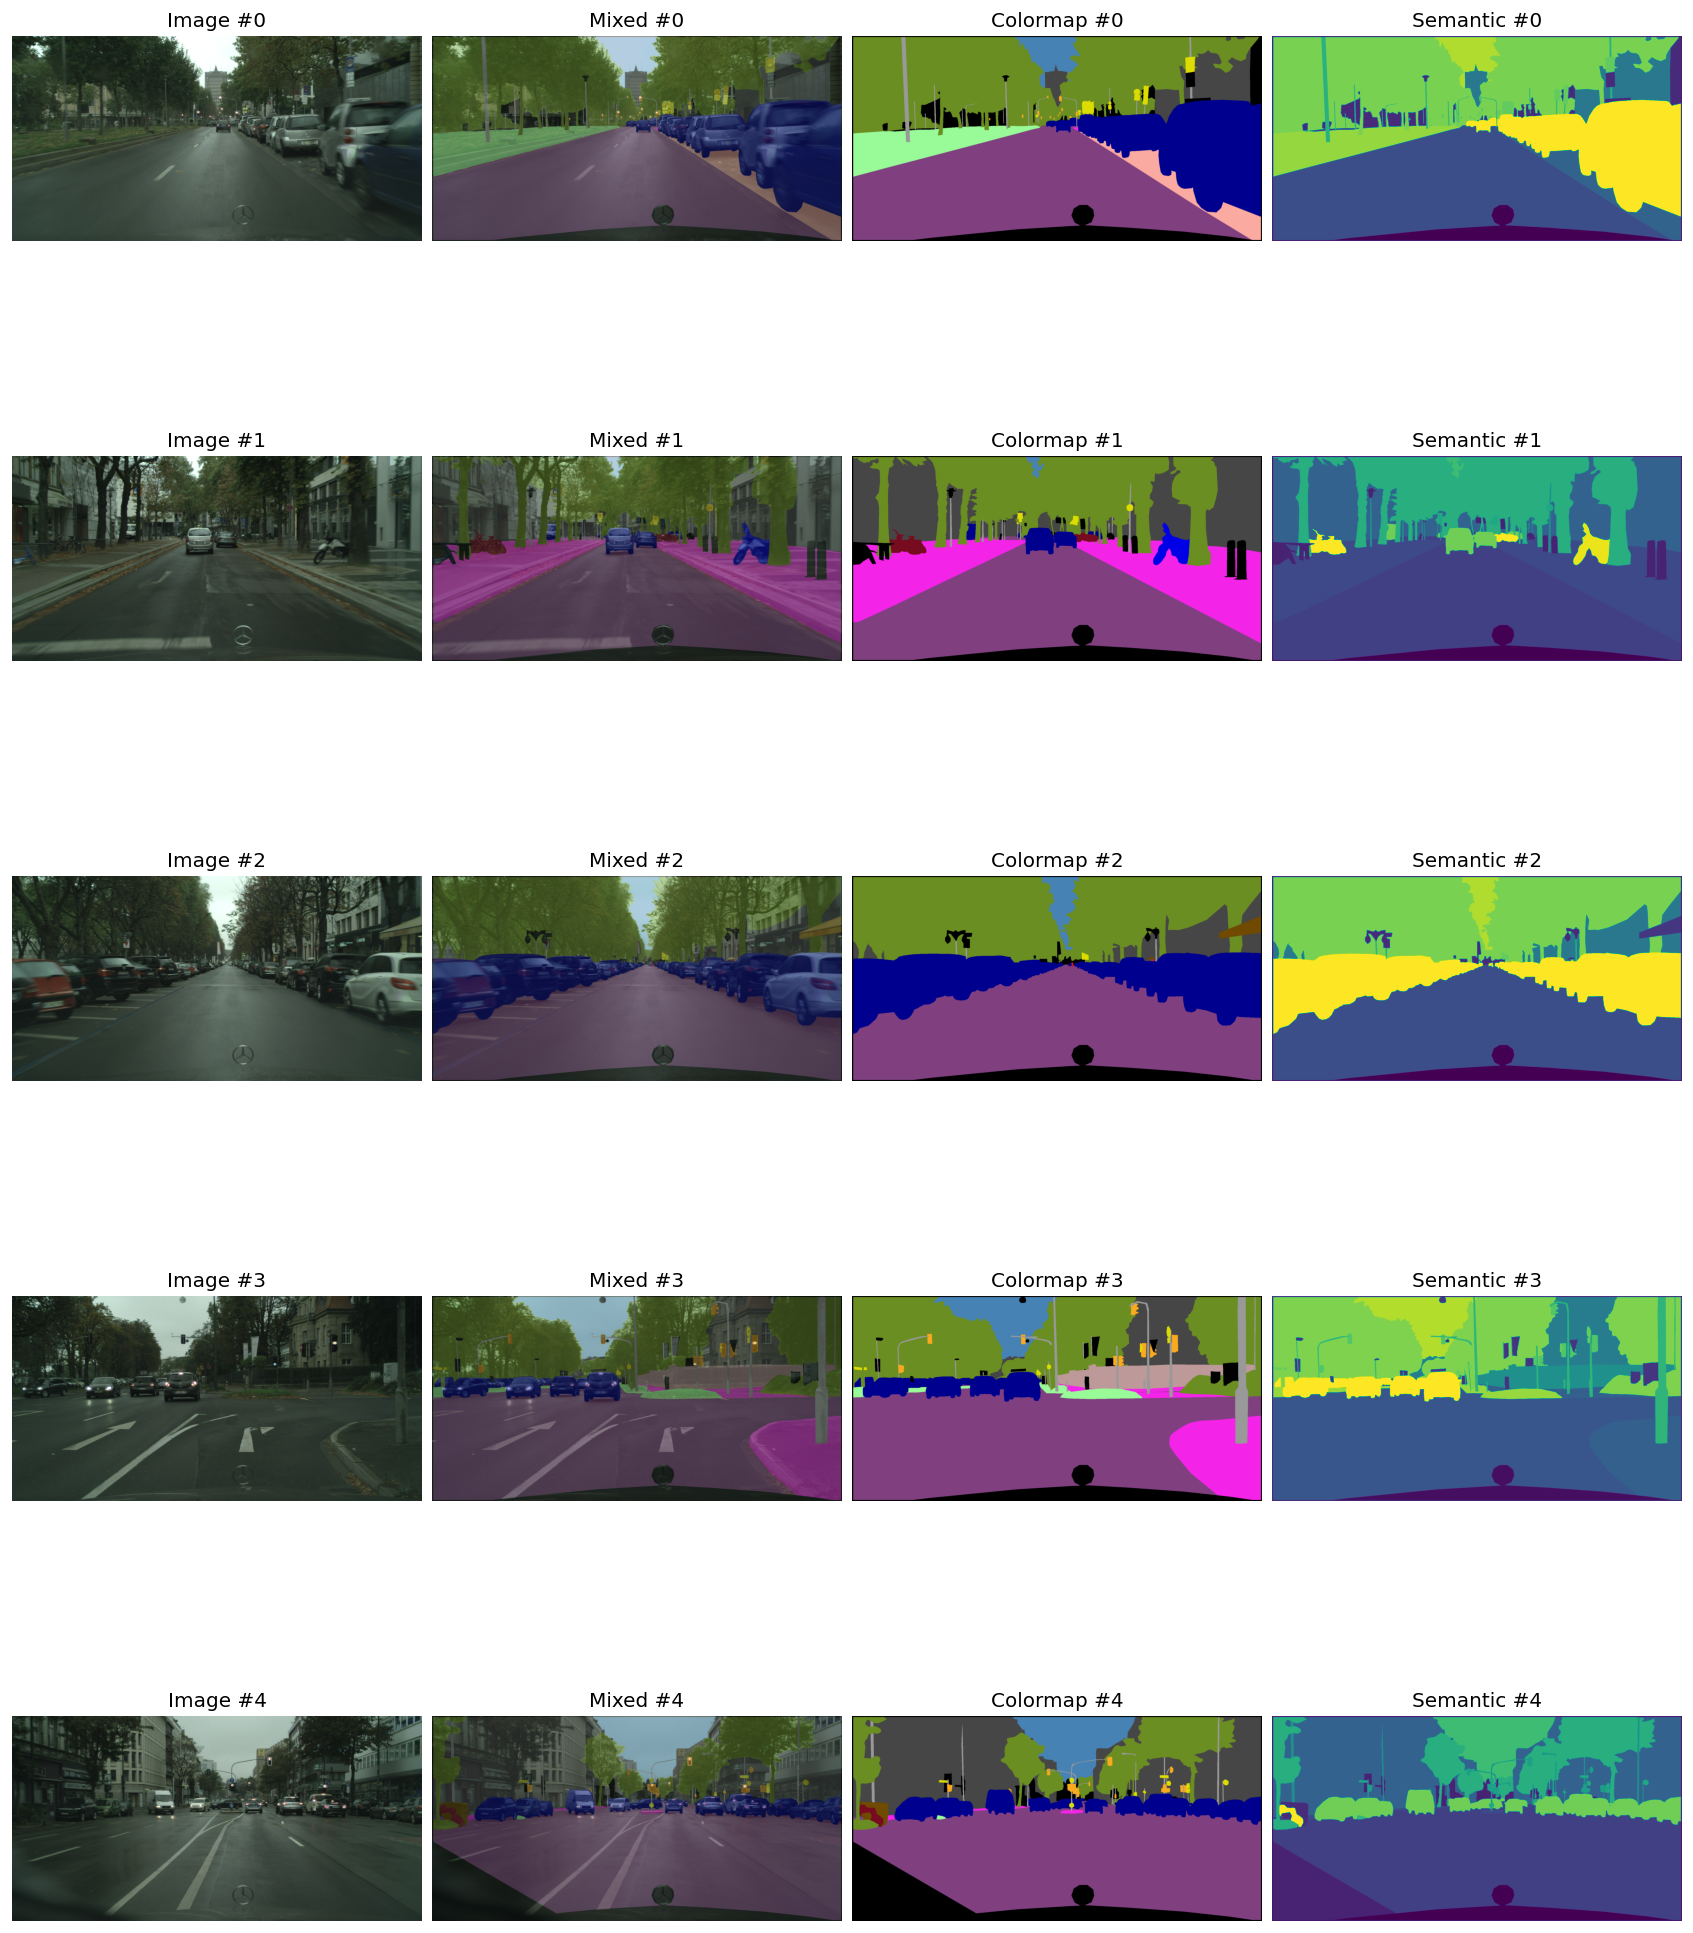

In [8]:
def show_dataset(ds):
    # Create our figure as a grid
    num_ims = 5
    ncols = 4
    nrows=num_ims

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True,\
                                 figsize=(3.5*ncols,3.5*nrows), facecolor='white')

    fig.set_dpi(120.0)

    # Mix the color image and original image into one
    def mix_images(img, col, im_per):
        col = torch.permute(col, (2,0,1))
        col = col[0:3]
        col = torch.permute(col, (1,2,0))

        mixed = (col*(1-im_per))/255+img*im_per

        return mixed

    # Plot the modified images
    for r in range(nrows):
        img, (inst, col, poly, sem) = ds[r]
        img = torch.permute(img, (1,2,0))
        col = transforms.functional.pil_to_tensor(col)
        col = torch.permute(col, (1,2,0))

        # Plot original image
        axs[r,0].set_axis_off()
        axs[r,0].set_title(f"Image #{r}")
        axs[r,0].imshow(img)

        # Plot colormap overlayed with original
        mixed = mix_images(img ,col, 0.6)
        axs[r,1].set_axis_off()
        axs[r,1].set_title(f"Mixed #{r}")
        axs[r,1].imshow(mixed)

        # Plot colormap
        axs[r,2].set_axis_off()
        axs[r,2].set_title(f"Colormap #{r}")
        axs[r,2].imshow(col)
        
        # Plot semantic data
        sem = transforms.functional.pil_to_tensor(sem)
        sem = torch.permute(sem, (1,2,0))
        axs[r,3].set_axis_off()
        axs[r,3].set_title(f"Semantic #{r}")
        axs[r,3].imshow(sem)

    plt.show()
    plt.close()

show_dataset(train_data)

Next, I'll look at the testing data:

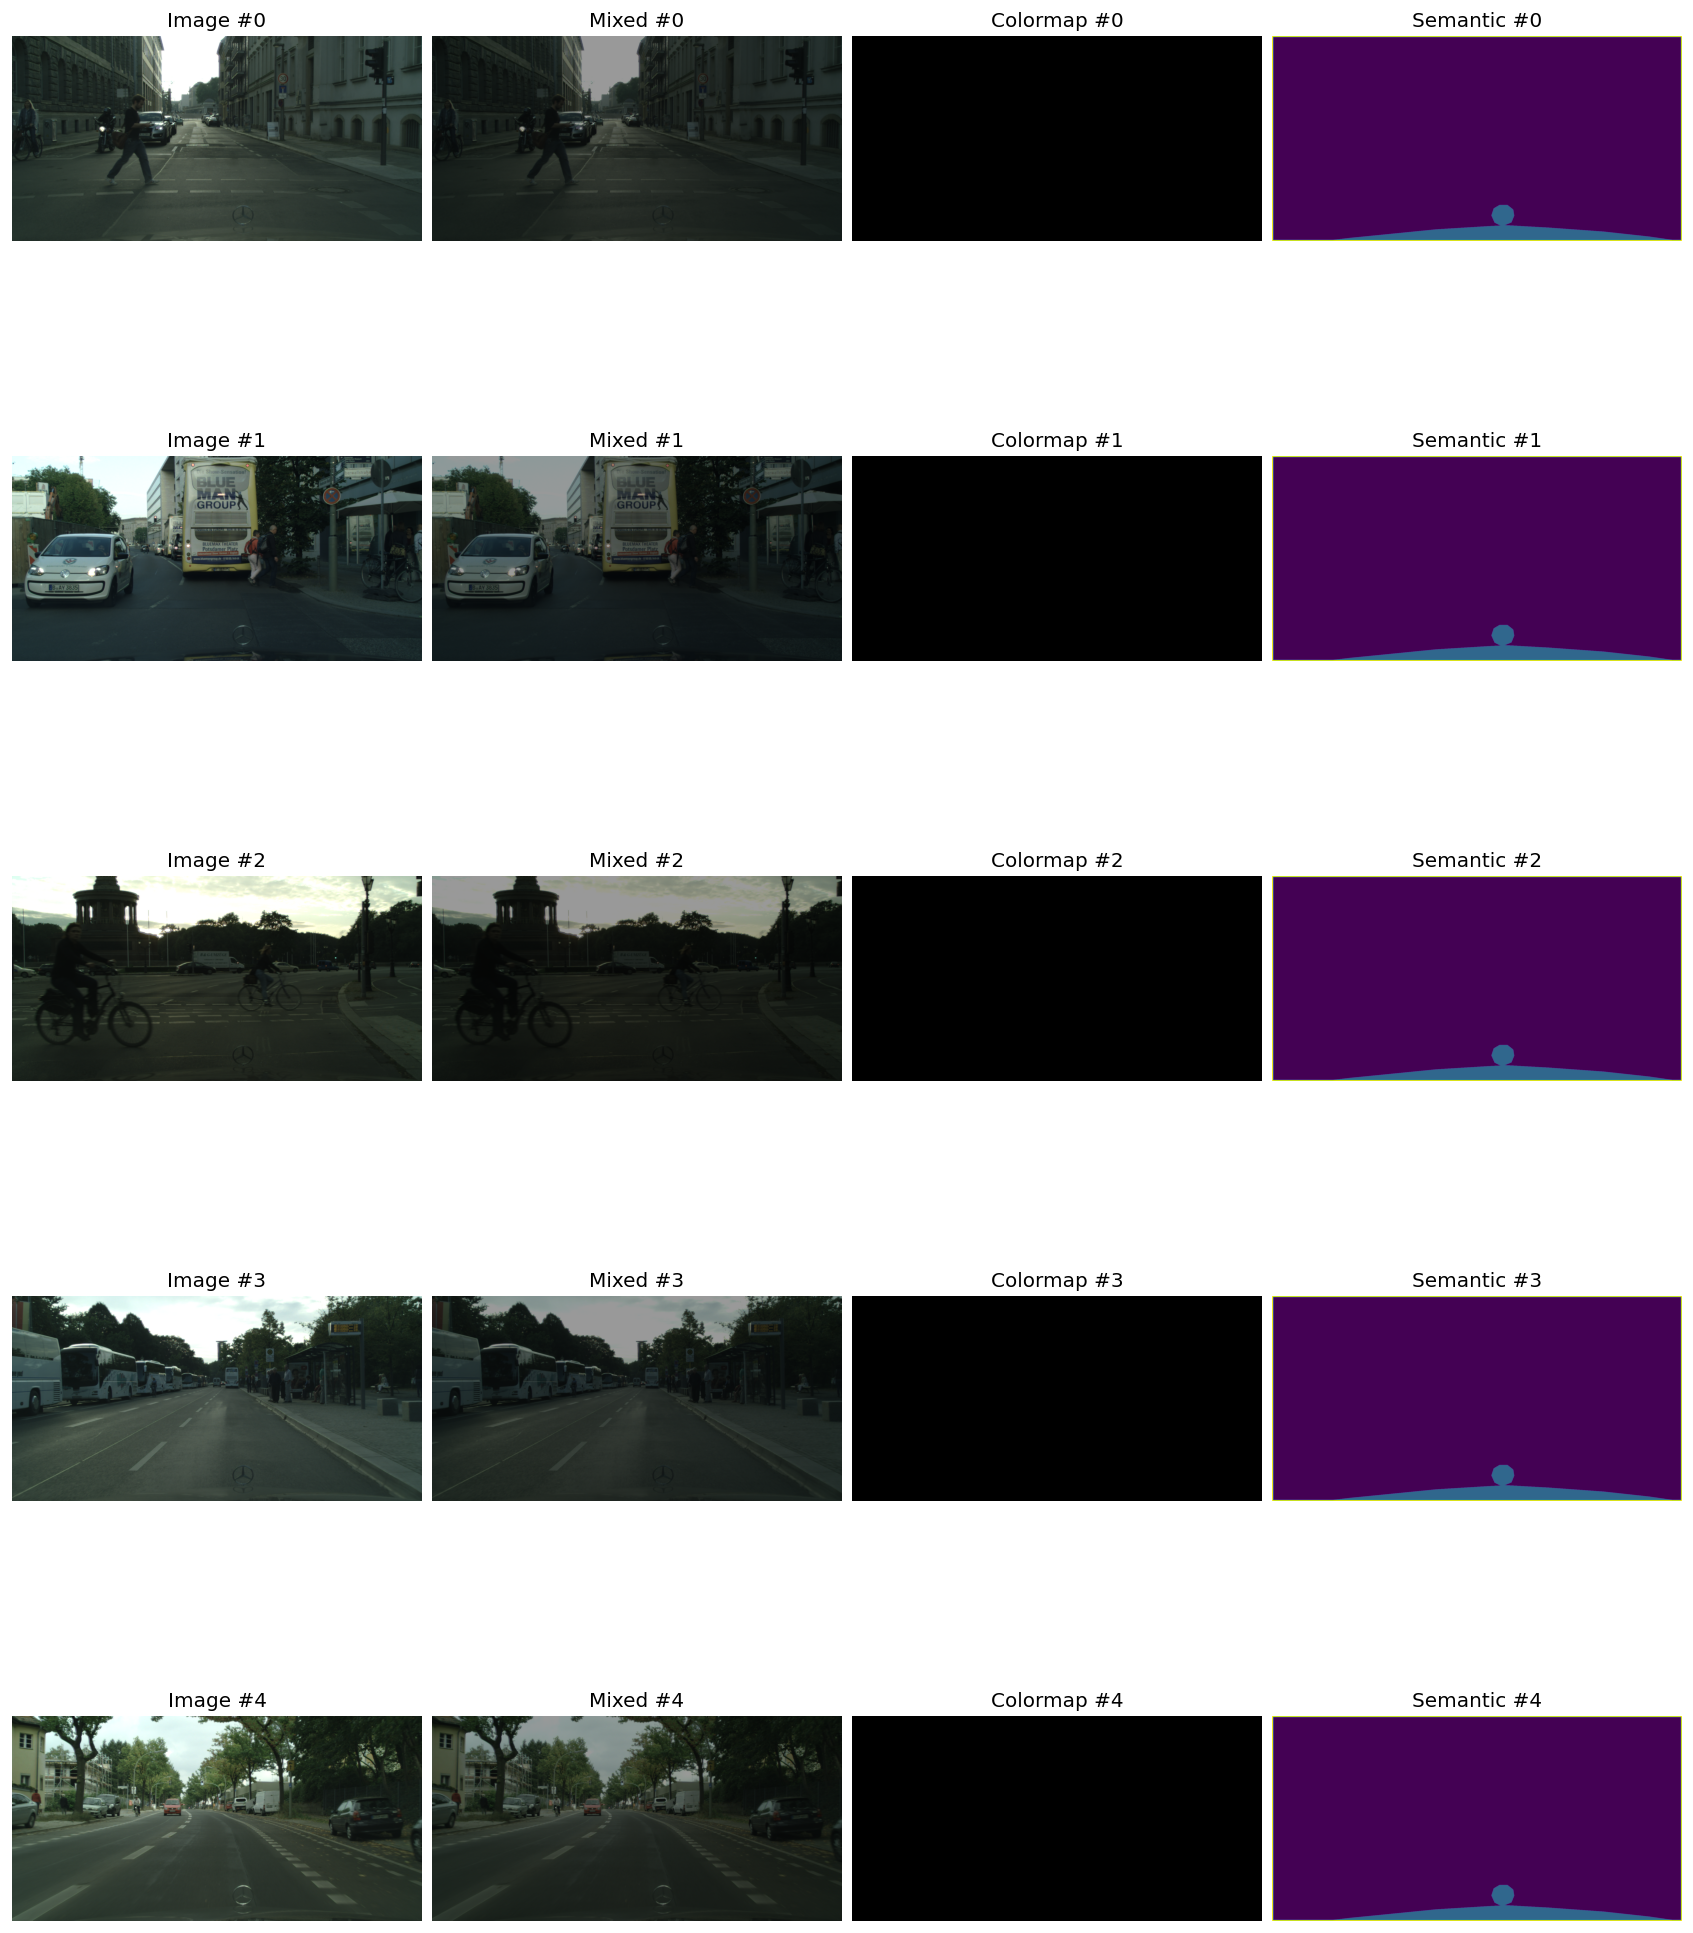

In [9]:
show_dataset(test_data)

Finally, I'll look at the validation data:

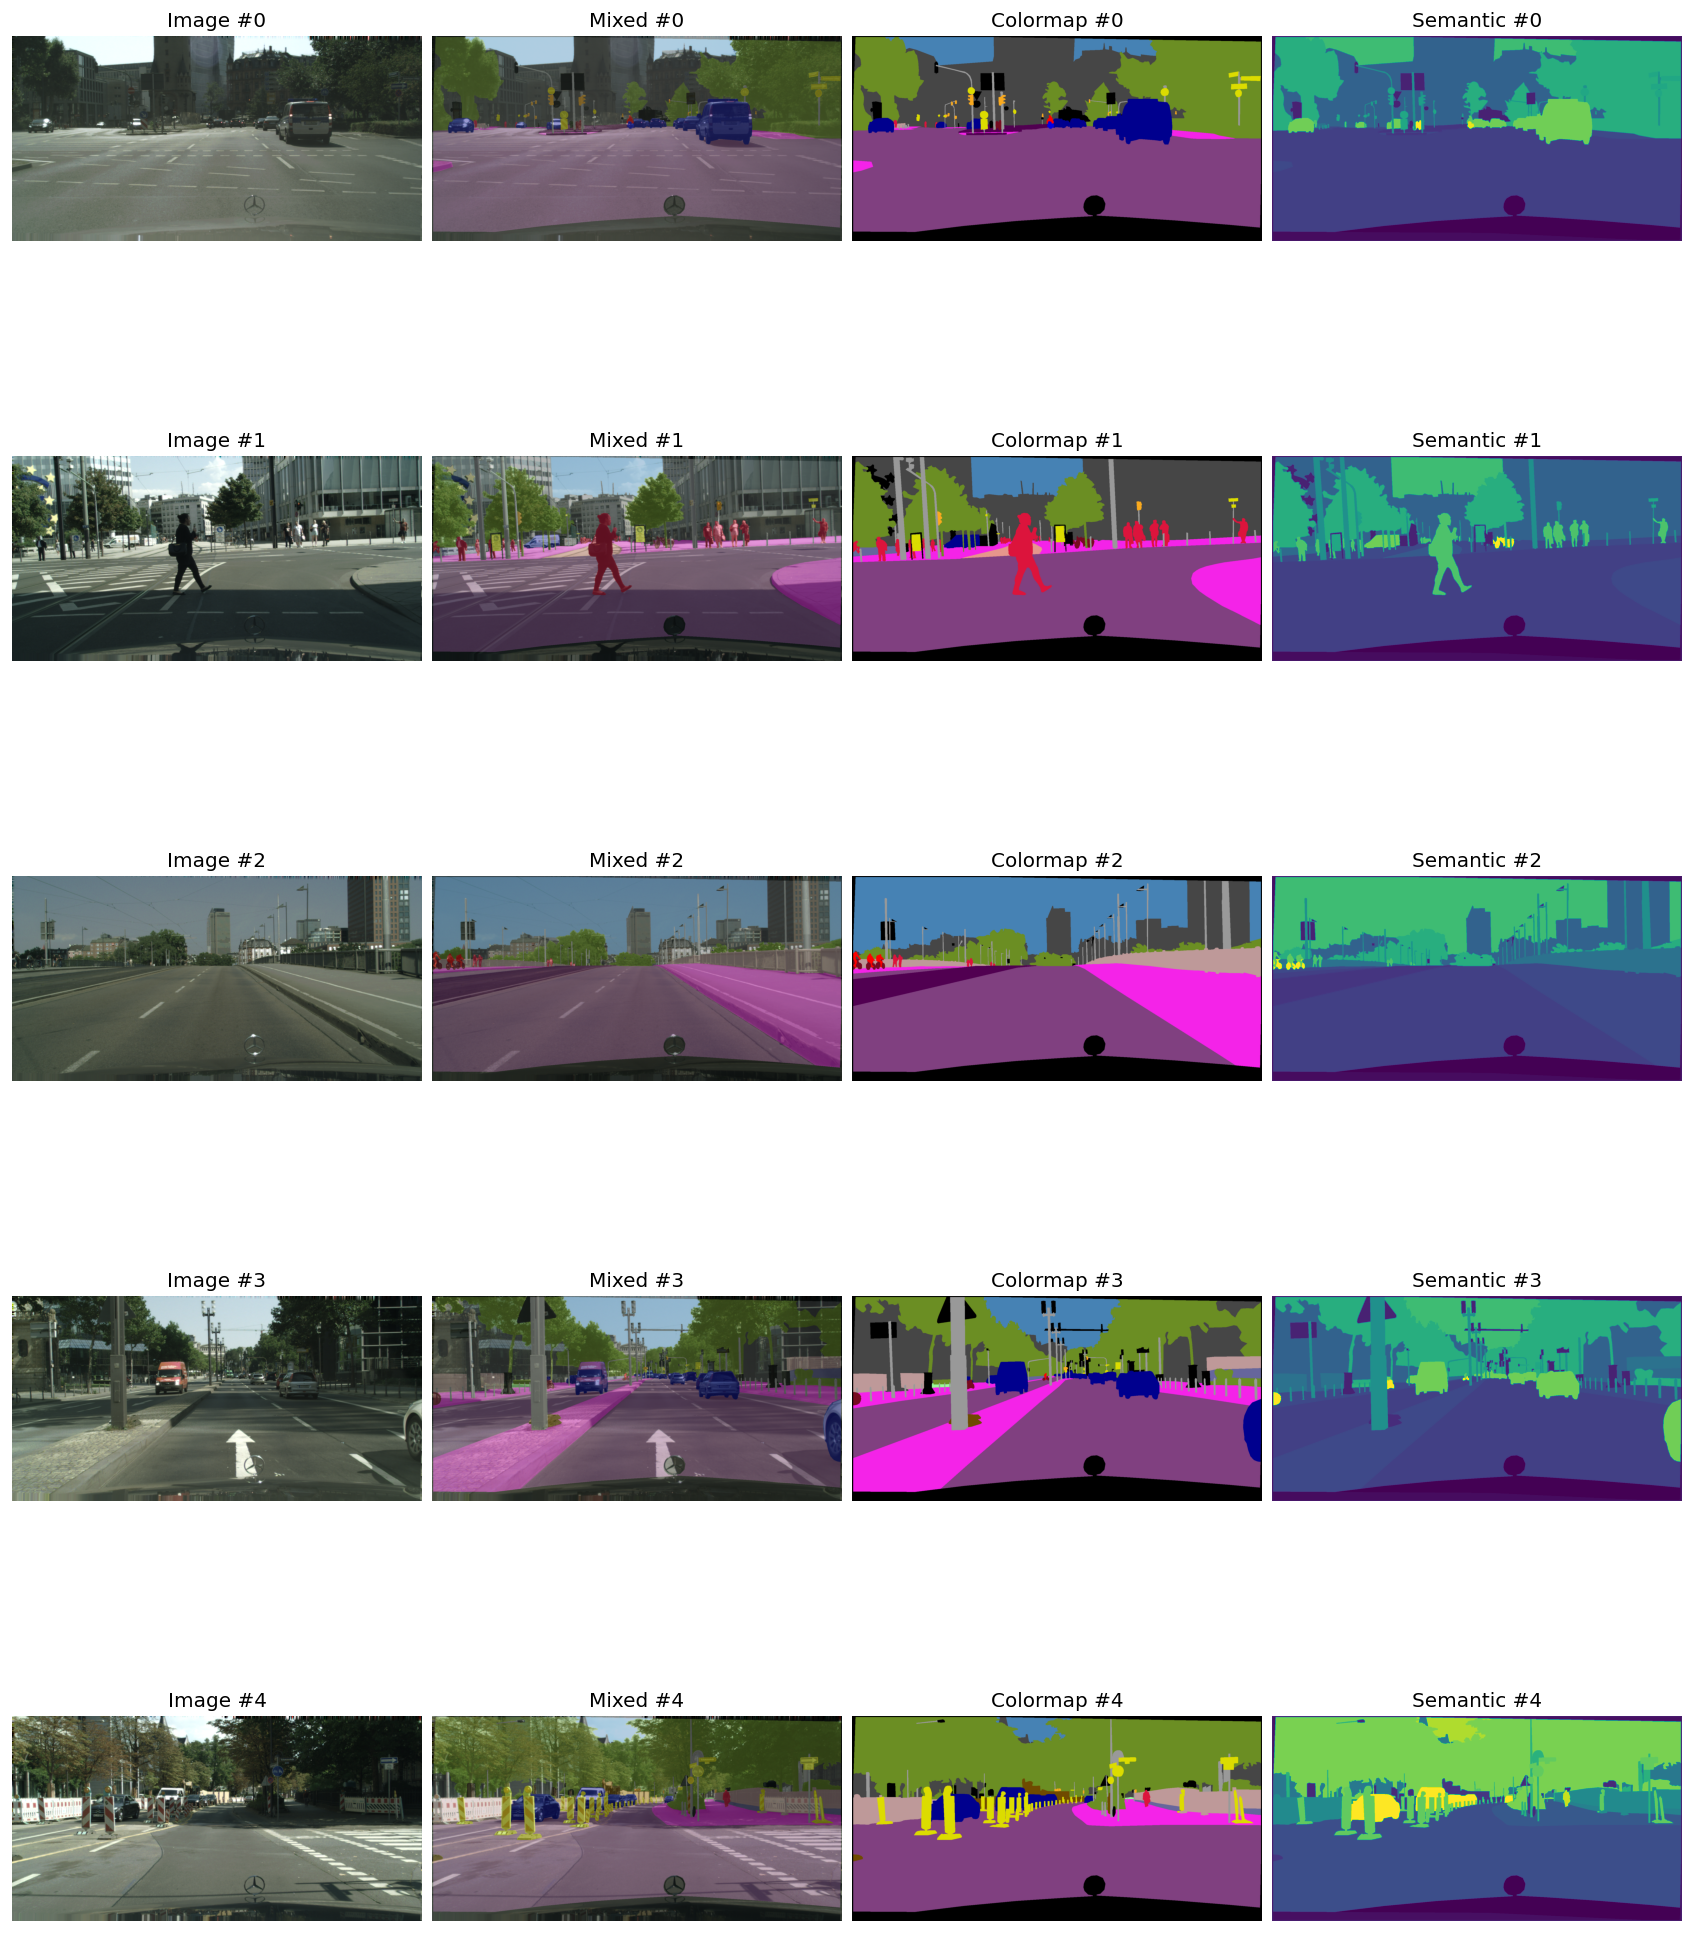

In [10]:
show_dataset(val_data)

Great! I really like second column of images, where I overlay the original and colormapped versions. It looks cool! What's interesting is it seems that the testing data isn't completely labeled. The vehicle that the images were taken from were labeled (in the semantic data), but nothing else. We should keep this in mind for the later figures. I'll now iterate over the entire dataset to collect data I find interesting and then I'll display it.

In [11]:
# Datasets: train_data, test_data, val_data
# Num images: How many images to process per dataset
num_images = [len(train_data),len(test_data),len(val_data)]
#num_images = [1,1,1]

# Store number of each type of pixel as a percentage
pixel_counts = np.zeros((3, 35))

# Store average position of each type of pixel
avg_x_pos = np.zeros((3,35))
avg_y_pos = np.zeros((3,35))

# Iterate over each pixel in each image in each dataset
#datasets = [train_data]
datasets = [train_data, test_data, val_data]

for i in range(len(datasets)):
    ds = datasets[i]
    for j in range(num_images[i]):
        # Transform image to semantic
        img, (inst, col, poly, sem) = ds[j]
        sem_t = transforms.functional.pil_to_tensor(sem)
        sem_t = torch.permute(sem_t, (1,2,0))
        # Iterate over pixels
        for r in range(h):
            for c in range(w):
                # Get label for this pixel
                color = sem_t[r][c].item()
                # Increment count for this label in this dataset
                pixel_counts[i][color] += 1
                # Increment position for this label in avg_x_pos and avg_y_pos
                avg_x_pos[i][color] += c
                avg_y_pos[i][color] += r
    # Turn x,y positions of each pixel into averages 
    # Calculate percentage of each type of pixel
    # evade divide by zero for averages
    total_pixels = sum(pixel_counts[i])
    for j in range(35):
        if pixel_counts[i][j] != 0:
            avg_x_pos[i][j] /= pixel_counts[i][j]
            avg_y_pos[i][j] /= pixel_counts[i][j]
    pixel_counts[i] = pixel_counts[i] / total_pixels

Below are some bar charts showing the percentage for each label of each dataset!

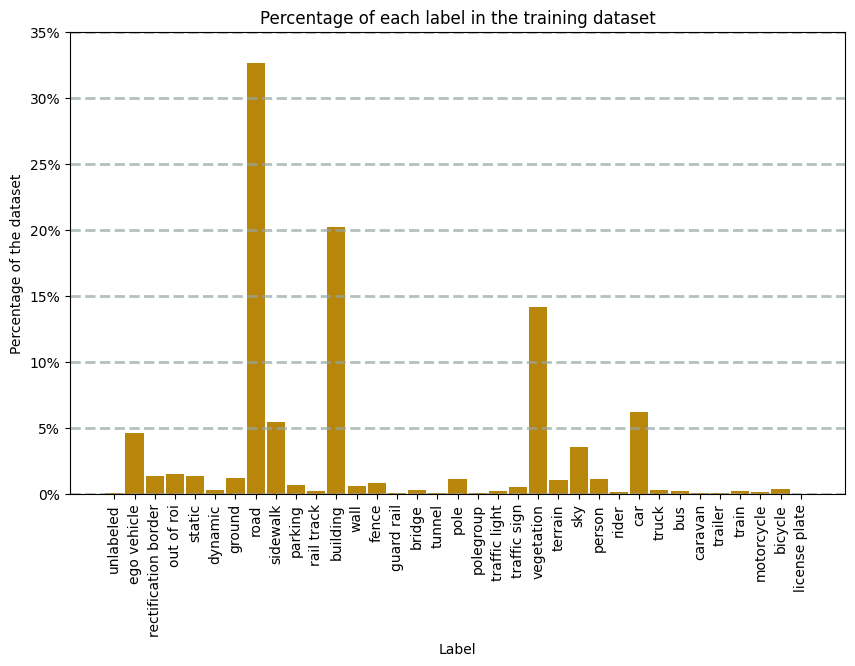

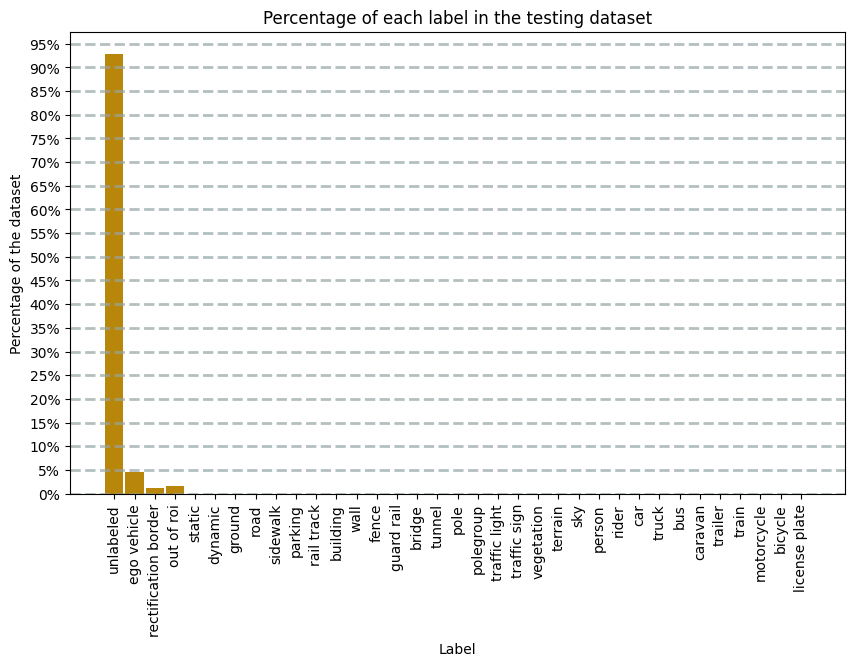

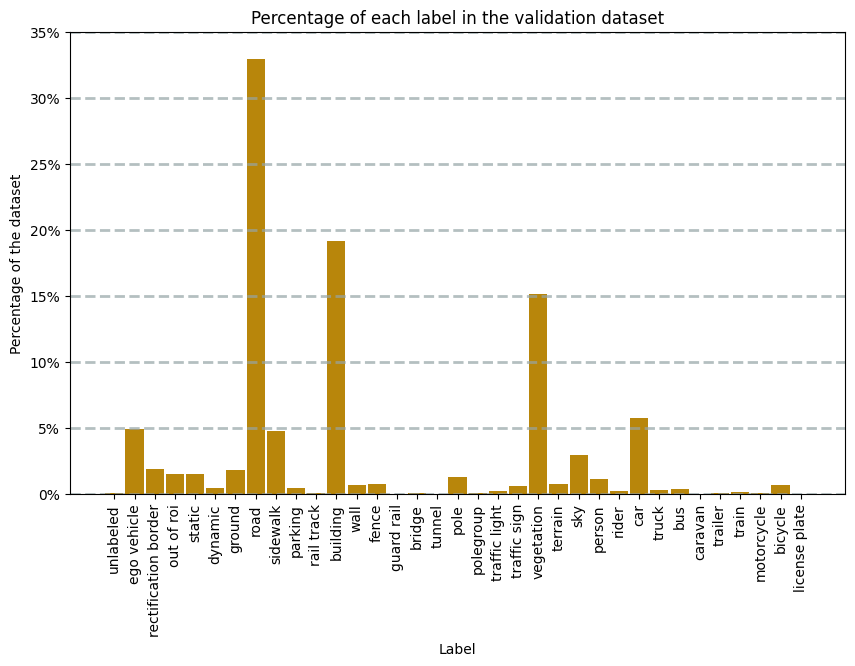

In [12]:
# Make our bar charts

# List of strings for the dataset names
dataset_names = ["training", "testing", "validation"]

# Get labels names
labels_str = list()
for i in range(len(labels)):
    labels_str.append(labels[i][0])

# Make bar chart plot for percentage of labels in the datasets
for i in range(len(datasets)):
    # Get max y value to scale y-axis
    max_y = round(max(pixel_counts[i]),1)
    
    # Plot our bar chart
    plt.figure(figsize=[10,6])
    plt.bar(range(35), pixel_counts[i], 0.9, color='darkgoldenrod')
    plt.xticks(range(35), labels_str, rotation='vertical')
    ticks_list = np.arange(0,max_y+0.06,0.05)
    plt.yticks(ticks_list, [f'{int(val*100):d}%' for val in ticks_list])
    # Next line copied from here: https://pythonbasics.org/matplotlib-bar-chart/
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.ylabel("Percentage of the dataset")
    plt.xlabel("Label")
    plt.title(f"Percentage of each label in the {dataset_names[i]} dataset")
    plt.show()
    plt.close()

From the above, we once again see that the testing dataset is strange. It doesn't appear to be very labeled. As such, I'll ignore it, but it's interesting that it is not labeled. As for the other two datasets (the validation and training dataset):

- Most of the images appear to be road, building, and vegitation.
- They both appear to have equal percentages of each label, which is a good thing!
- They also appear to have most labels appear in the dataset, though through the bar chart it's hard to tell if things like "guard rail" appear in any image.

I was also curious where the average location of each label in each dataset resides! I show this in some scatter plots below.

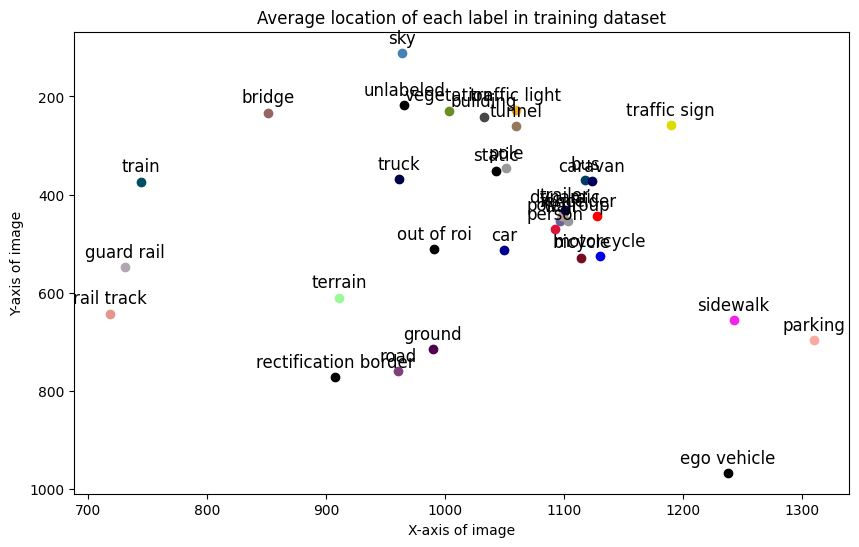

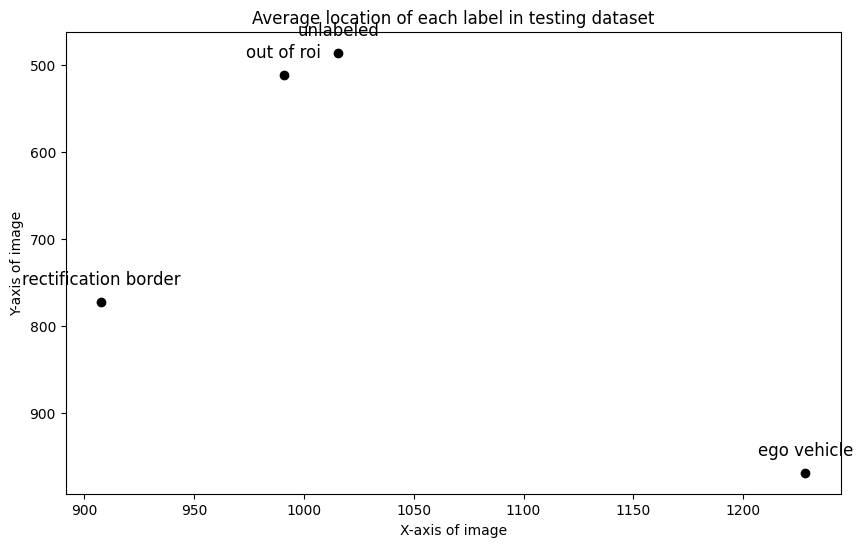

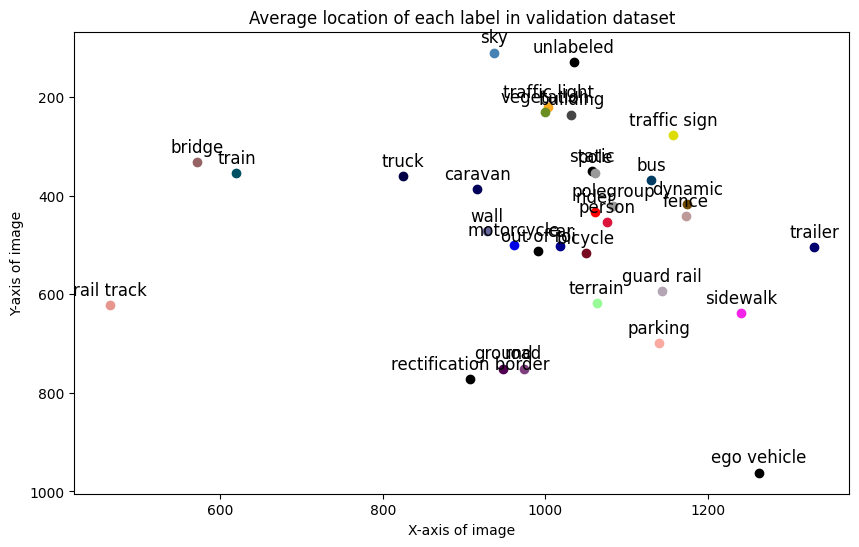

In [13]:
# Make our scatter plots

# Make bar chart plot for percentage of labels in the datasets
for i in range(len(datasets)):
    plt.figure(figsize=[10,6])
    
    # Plot our scatter plot
    for j in range(35):
        color = np.asarray(labels[j][7])/255
        x_pos = avg_x_pos[i][j]
        y_pos = avg_y_pos[i][j]
        if x_pos == 0. and y_pos == 0.:
            continue
        plt.scatter(x_pos, y_pos, color=color)
        plt.text(x_pos,y_pos-20,labels_str[j],fontsize=12, ha='center')
    
    plt.gca().invert_yaxis()
    plt.ylabel("Y-axis of image")
    plt.xlabel("X-axis of image")
    plt.title(f"Average location of each label in {dataset_names[i]} dataset")
    plt.show()
    plt.close()

From the above, we can once again discount the testing dataset. As for the other two, we can make some inferences:

- Some labels appear in the same place, on average, between the two datasets, such as: sidewalk, traffic sign, sky, and truck. This could make using models trained on this dataset less adaptable to real world situations where the labels aren't always in the same average location.
- The average location of all labels appear to be toward the right-center of the image. This, once again, could cause problems for segmentation models on the left part of the iamge where we encounter less varied data.

As a result, if this dataset is used to train something like an autonomous vehicle, the position of the camera used in the vehicle is incredibly important so that real data is as similar to data in this dataset as possible.

Lastly, I want to see the composition of the sizes of each image in the dataset.

In [27]:
# Datasets: train_data, test_data, val_data
# Num images: How many images to process per dataset
num_images = [len(train_data),len(test_data),len(val_data)]
#num_images = [3,3,3]

# Store image sizes
im_heights = [dict(),dict(),dict()]
im_widths = [dict(),dict(),dict()]
im_features = [dict(),dict(),dict()]

# Iterate over each pixel in each image in each dataset
#datasets = [train_data]
datasets = [train_data, test_data, val_data]

for i in range(len(datasets)):
    ds = datasets[i]
    for j in range(num_images[i]):
        # Transform image to semantic
        img, (inst, col, poly, sem) = ds[j]
        img = torch.permute(img, (1,2,0))
        # Get image size
        sz = img.size()
        h = sz[0]
        w = sz[1]
        p = sz[2]
        # Store image size
        im_heights[i][h] = im_heights[i].get(h,0)+1
        im_widths[i][w] = im_widths[i].get(w,0)+1
        im_features[i][p] = im_features[i].get(p,0)+1


In [28]:
print(im_heights)
print(im_widths)
print(im_features)

[{1024: 2975}, {1024: 1525}, {1024: 500}]
[{2048: 2975}, {2048: 1525}, {2048: 500}]
[{3: 2975}, {3: 1525}, {3: 500}]


From the above, we can see that for each dataset, each image is 1024x2048x3.

This completes my EDA on Cityscapes! I hope you enjoyed it:) Below is an interesting data point about how long it took me to do EDA by iterating over each pixel in each image in each of the testing/training/validation datasets!

In [14]:
# End timer
end_time = time.time()
print("Total notebook time:", end_time-start_time, "seconds")

Total notebook time: 39201.51113533974 seconds


39201 seconds is just under 10.8 hours!